In [8]:
import numpy as np
import sys
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [19]:
#importing any stock (I'm using AAPL) stock data and writing to pandas DF
ticker = input("Enter stock ticker: ") 
stock = yf.Ticker(f"{ticker}")
data = stock.history(period="1y")[::-1] #reversing the data so it's decreasing in time
# API for yahoo is currently down, pushing it as is for now

$BA: possibly delisted; no price data found  (period=1y)


In [9]:
#If you want to get the data to a csv file
df.to_csv(f'{ticker}.csv')

In [12]:
#Basic EDA
# Display the first few rows of the dataframe
print(df.head())

# Get the summary statistics of the numerical columns
print(df.describe())

# Check the data types of each column
print(df.dtypes)

# Check the number of rows and columns in the dataframe
print(df.shape)

# Check for missing values in the dataframe
print(df.isnull().sum())


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
       Open  High  Low  Close  Adj Close  Volume
count   0.0   0.0  0.0    0.0        0.0     0.0
mean    NaN   NaN  NaN    NaN        NaN     NaN
std     NaN   NaN  NaN    NaN        NaN     NaN
min     NaN   NaN  NaN    NaN        NaN     NaN
25%     NaN   NaN  NaN    NaN        NaN     NaN
50%     NaN   NaN  NaN    NaN        NaN     NaN
75%     NaN   NaN  NaN    NaN        NaN     NaN
max     NaN   NaN  NaN    NaN        NaN     NaN
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object
(0, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


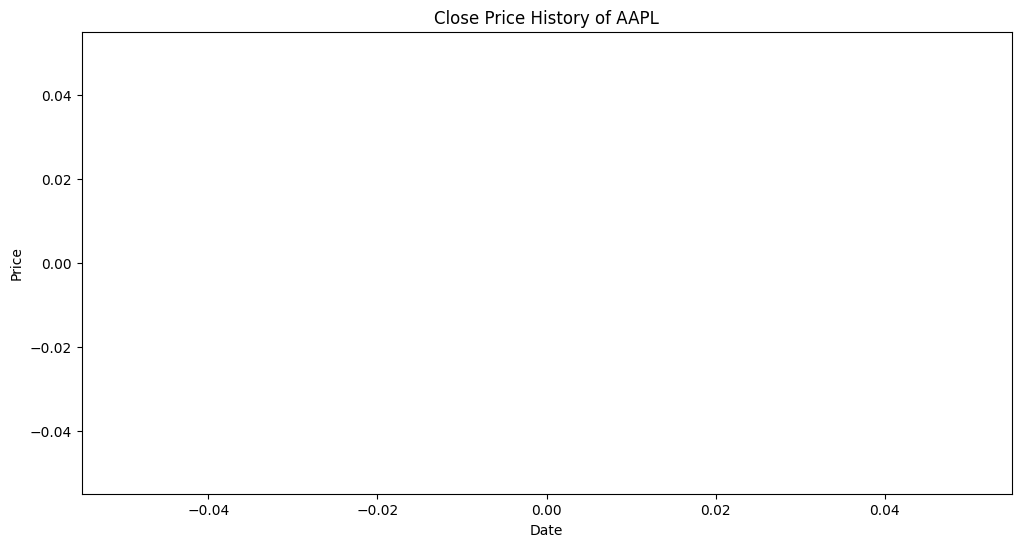

In [13]:
#Graphing the close vs time
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price history')
plt.title(f'Close Price History of {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [15]:
#Getting the delta values
close = df['Close'].values
delta = np.zeros_like(close)
delta[1:] = np.where(close[:-1] != 0, (close[1:] / close[:-1]) - 1, 0)

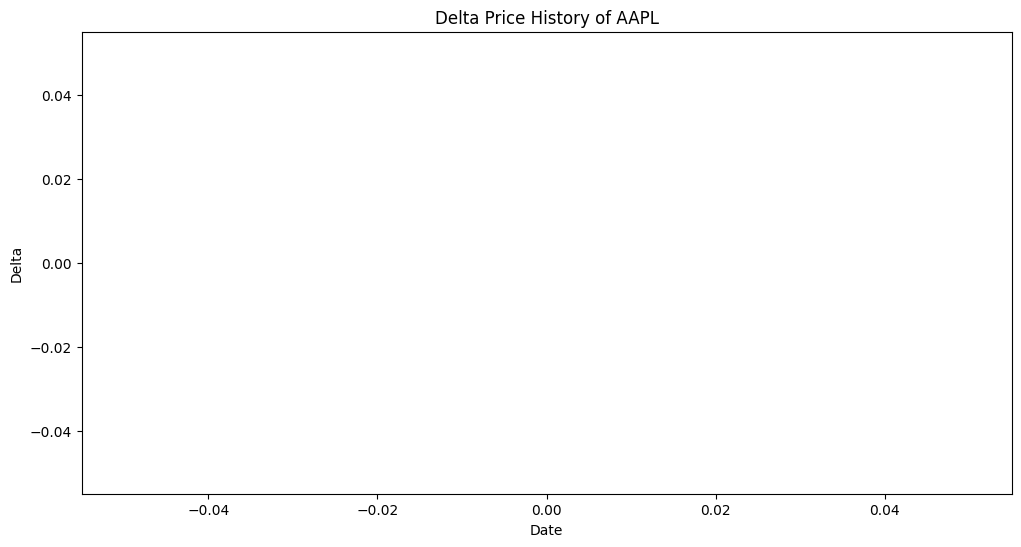

In [16]:
#Graphing the delta vs time
plt.figure(figsize=(12,6))
plt.plot(delta, label='Delta Price history')
plt.title(f'Delta Price History of {ticker}')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.show()

In [17]:
class NeuralNet(nn.Module):

    def __init__(self, inputs, outputs):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(inputs, 50)
        self.layer2 = nn.Linear(50, outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

class Normalize:

    def __init__(self, N):
        self.N = N

    def go(self, x):
        self.minx = []
        self.maxx = []
        y = np.array(x)
        for i in range(self.N):
            self.minx.append(np.min(y[:, i]))
            self.maxx.append(np.max(y[:, i]))
        return (y - np.array(self.minx))/(np.array(self.maxx) - np.array(self.minx))

    def back(self, x):
        y = np.array(x)
        return y*(np.array(self.maxx) - np.array(self.minx)) + np.array(self.minx)
        
def SplitData(p):
    def Problem(f):
        def Solve(*a, **b):
            inputs, outputs = f(*a, **b)
            I = int(p*len(inputs))
            trainX = inputs[:I]
            trainY = outputs[:I]
            testX = inputs[I:]
            return trainX, trainY, testX
        return Solve
    return Problem


def Volatility(close, window=100, output=30):
    ror = close[1:]/close[:-1] - 1.0
    volx = []
    for i in range(window, len(ror)):
        volx.append(np.std(ror[i-window:i]))
    return volx

@SplitData(0.7)
def VolDataset(vx, window=30, output=10):
    inputs = []
    outputs = []
    for i in range(window, len(vx)-output+1):
        inputs.append(vx[i-window:i])
        outputs.append(vx[i:i+output])
    return np.array(inputs), np.array(outputs)

@SplitData(0.7)
def GoodVsBadVol(close, window=100, output=30):
    cr = lambda x: np.prod([(1 + r) for r in x]) - 1.0
    vin = []
    vout = []
    ror = close[1:]/close[:-1] - 1.0
    sror = ror[window:]
    svol = Volatility(close)
    for i in range(window, len(svol)-output+1):
        vin.append(svol[i-window:i])
        vout.append(1 if cr(sror[i:i+output]) > 0 else 0)
    return vin, vout
    

vx = Volatility(close)

vin, vout, vtest = VolDataset(vx)

nin = Normalize(30)
nout = Normalize(10)
ntest = Normalize(30)
nsvin = Normalize(100)
nsvtest = Normalize(100)

normIN = nin.go(vin)
normOUT = nout.go(vout)
normTEST = ntest.go(vtest)

svin, svout, svtest = GoodVsBadVol(close)

normSIN = nsvin.go(svin)
normSTEST = nsvtest.go(svtest)

model = SVC(kernel='linear', probability=True)
model.fit(normSIN, svout)

goodbad = model.predict(normSTEST)
gbprob = model.predict_proba(normSTEST)

good = sum([1 for i in goodbad if i == 1])
bad = sum([1 for i in goodbad if i == 0])
goodClass = np.mean(gbprob[:, 0])

IN = torch.stack([torch.tensor(i, dtype=torch.float32) for i in normIN])
OUT = torch.stack([torch.tensor(i, dtype=torch.float32) for i in normOUT])
TEST = torch.stack([torch.tensor(i, dtype=torch.float32) for i in normTEST])

lr = 0.0001

nmodel = NeuralNet(30, 10)
criterion = nn.MSELoss()
optimizer = optim.Adam(nmodel.parameters(), lr=lr)

epochs = 400

for epoch in range(epochs):
    output = nmodel(IN)
    loss = criterion(output, OUT)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch: ", epoch+1)

with torch.no_grad():
    testout = nmodel(TEST)

forecast = testout.numpy()
forecast = nout.back(forecast)
forecast = forecast[-1]

plotvol = vx[-30:]
xvol = range(len(plotvol))

fvol = range(len(plotvol), len(plotvol)+len(forecast))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

title = f'Good Volatility: {good} | Bad Volatility: {bad} | Correct: {goodClass}'

ax.set_title(title)
ax.set_xlabel('Time')
ax.set_ylabel('Volatility')
ax.plot(xvol, plotvol, color='red')
ax.plot(fvol, forecast, color='limegreen')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'WFC.csv'

In [ ]:
# Value at Risk and expected shortfall

# Define the number of days
n = input("Enter number of holding days")
# Value at Risk


# Calculate the value at risk
var = np.percentile(forecast, 5)

# Print the value at risk
print(f"Value at Risk for {n} days: {var}")

# Expected Shortfall

# Calculate the expected shortfall
expected_shortfall = np.mean(forecast[forecast <= var])

# Print the expected shortfall
print(f"Expected Shortfall for {n} days: {expected_shortfall}")


